# Dog Breed Identification : Modèle Xception avec ImageDataGenerator

Nous allons utiliser le modèle Xception de la bibliothèque `tensorflow.keras.applications` sur des données importées avec `ImageDataGenerator` en ajustant quelques hyper-paramètres.

## Préparation de l'environnement du travail

### Importation des packages

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
import pickle

Regardons combien de GPUs disponible (que nous pouvons utiliser)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Dézipper le fichier de données

In [4]:
zip_ref = zipfile.ZipFile("dog-breed-identification.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Récupération des données

Les données sont en deux parties: 
1. Le ficher `labels.csv` qui contient les `id` des images (le nom de fichier image sans extension) liés à leur modalité `breed`.
2. Le dossier `train` avec les images en format jpg.

Commençant par ajouter l'extension `.jpg` aux id des images dans `labels.csv` pour faciliter les tâches par la suite.

In [5]:
def append_ext(fn):
  return fn+".jpg"

In [6]:
df_train = pd.read_csv("/tmp/labels.csv")
df_train['id'] = df_train['id'].apply(append_ext)
labelNames = df_train["breed"].unique()
labelNames.shape

(120,)

Nous avons 120 types de chiens (120 modalités), et 10222 images dans le dossier train.

In [7]:
df_train.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

## Création du modèle

Avant de passer à l'entraînement, nous allons formatez les images en `tensors` à virgule flottante en les prétraitant de la manière suivante :

1.   Lire les images du disque.
2.   Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RGB.
3.   Convertir les en `tensors` à virgule flottante des valeurs entre 0 et 255 à des valeurs comprises entre 0 et 1.
4.   Redimensionnez les images.

Ces étapes sont faites grâce à `ImageDataGenerator` de la bibliothèque `tf.keras`.

### Hyper-paramètres

Fixant quelques hyper-paramètres et les variables qui seront utilisés pour l'entraînement :

In [9]:
PATH = "/tmp/"
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
batch_size = 40
epochs = 50
IMG_SIZE = 128
learning_rate = 0.001
input_shape = (IMG_SIZE, IMG_SIZE, 3)
image_generator = ImageDataGenerator(rescale=1./255,
                                     validation_split=0.15,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     fill_mode="nearest"
                                    )

En créant l'instance d'ImageDataGenerator, nous avons présicé `rescale` pour normaliser les valeurs des pixels (0-255) à des valeurs (0-1).
La taille de validation dataset `validation_split` à 15%.
Pour augmenter les données, horizontal_flip est à True, width_shift_range et height_shift_range à 0.2. Avec fill_mode à `nearest` pour remplir le vide.

### Récupération des données (les images) avec ImageDataGenerator

In [10]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=df_train,
                                                     batch_size=batch_size,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="breed",
                                                     subset="training",
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE))

Found 8689 validated image filenames belonging to 120 classes.


In [11]:
valid_data_gen = image_generator.flow_from_dataframe(dataframe=df_train,
                                                     batch_size=batch_size,
                                                     directory=train_dir,
                                                     x_col="id",
                                                     y_col="breed",
                                                     subset="validation",
                                                     shuffle=True,
                                                     class_mode="categorical",
                                                     target_size=(IMG_SIZE, IMG_SIZE))

Found 1533 validated image filenames belonging to 120 classes.


In [12]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

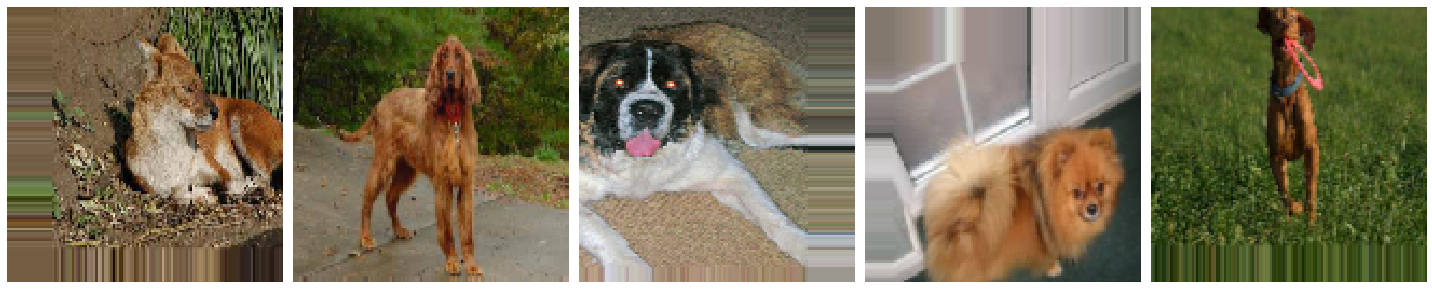

In [13]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images)

### Création du réseau de neurones `Xception`

In [14]:
modelXception = Xception(weights = None,input_shape=input_shape, pooling='max', classes=120)
modelXception.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_

Choisissons `accuracy` comme metrique et `Adam` comme optimisateur, avec learning_rate = 0.001 : 

In [15]:
opt = Adam(lr=learning_rate)

modelXception.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle : 

In [16]:
historyXception = modelXception.fit_generator(
    train_data_gen,
    steps_per_epoch=8689 // batch_size,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=1533 // batch_size
)

Epoch 1/50
217/217 [==============================] - 99s 457ms/step - loss: 4.7218 - acc: 0.0194 - val_loss: 4.7868 - val_acc: 0.0125
Epoch 2/50
217/217 [==============================] - 78s 362ms/step - loss: 4.4160 - acc: 0.0356 - val_loss: 4.7745 - val_acc: 0.0079
Epoch 3/50
217/217 [==============================] - 78s 362ms/step - loss: 4.2165 - acc: 0.0554 - val_loss: 4.5870 - val_acc: 0.0414
Epoch 4/50
217/217 [==============================] - 78s 362ms/step - loss: 4.0388 - acc: 0.0730 - val_loss: 8.8363 - val_acc: 0.0191
Epoch 5/50
217/217 [==============================] - 78s 361ms/step - loss: 3.9188 - acc: 0.0853 - val_loss: 6.1336 - val_acc: 0.0408
Epoch 6/50
217/217 [==============================] - 78s 360ms/step - loss: 3.7929 - acc: 0.1034 - val_loss: 6.0273 - val_acc: 0.0434
Epoch 7/50
217/217 [==============================] - 78s 361ms/step - loss: 3.6920 - acc: 0.1171 - val_loss: 5.4640 - val_acc: 0.0776
Epoch 8/50
217/217 [==============================] - 7

In [19]:
modelXception.save("models/Xception/modelXception2.h5")
with open('models/Xception/modelXception2HistoryDict', 'wb') as file_pi:
        pickle.dump(historyXception.history, file_pi)

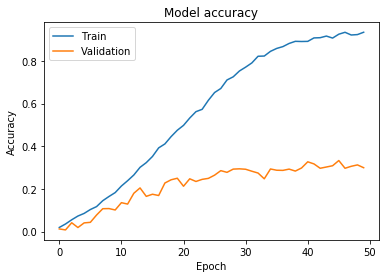

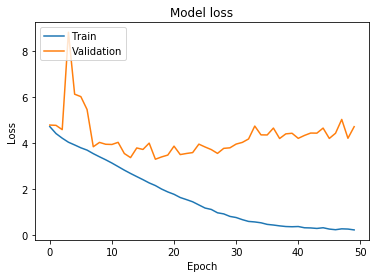

In [18]:
plt.plot(historyXception.history['acc'])
plt.plot(historyXception.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyXception.history['loss'])
plt.plot(historyXception.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()